In [1]:
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 16.0 MB/s eta 0:00:00


In [2]:
!python -m spacy download de_core_news_sm

2023-04-11 08:53:58.904146: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-11 08:53:59.904961: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-11 08:54:01.175066: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-11 08:54:01.175549: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [3]:
!python -m spacy download fr_core_news_sm

2023-04-11 08:54:27.362878: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-11 08:54:28.396111: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-11 08:54:29.671430: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-11 08:54:29.671847: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [4]:
import io
import math
import time
from tqdm import tqdm
from collections import Counter

import torch
import numpy as np
import scipy.spatial
import torch.nn as nn
from torch import Tensor
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch.nn import (TransformerEncoder, TransformerDecoder,
                      TransformerEncoderLayer, TransformerDecoderLayer)

import torchtext
from torchtext.vocab import vocab
from torchtext.data.utils import get_tokenizer
from torchtext.utils import download_from_url, extract_archive

from transformers import AutoModel, AutoTokenizer, AutoModelForSeq2SeqLM
import matplotlib.pyplot as plt
from datasets import load_dataset

In [5]:
_ = torch.manual_seed(0)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
def flatten_t(batch):
    batch['en'] = batch['translation']['en']
    batch['de'] = batch['translation']['de']
    return batch

def flatten_s(batch):
    batch['fr'] = batch['translation']['fr']
    batch['en'] = batch['translation']['en']
    return batch

def build_vocab(ds, tokenizer):
    counter = Counter()
    for string_ in ds:
        counter.update(tokenizer(string_))
    return vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])

def data_process(raw_src_data, raw_tgt_data, vocab_src, vocab_tgt, tokenizer_src, tokenizer_tgt):
    raw_src_iter = iter(raw_src_data)
    raw_tgt_iter = iter(raw_tgt_data)
    data = []
    for (raw_src, raw_tgt) in tqdm(zip(raw_src_iter, raw_tgt_iter)):
        src_tensor_ = torch.tensor(
            [vocab_src[token] for token in tokenizer_src(raw_src.rstrip("\n"))],
            dtype=torch.long)
        tgt_tensor_ = torch.tensor(
            [vocab_tgt[token] for token in tokenizer_tgt(raw_tgt.rstrip("\n"))],
            dtype=torch.long)
        data.append((src_tensor_, tgt_tensor_))
    return data

def generate_batch(data_batch):
    src_batch, tgt_batch = [], []
    for (src_item, tgt_item) in data_batch:
        src_batch.append(torch.cat([torch.tensor([2]), src_item, torch.tensor([3])], dim=0))
        tgt_batch.append(torch.cat([torch.tensor([2]), tgt_item, torch.tensor([3])], dim=0))
    src_batch = pad_sequence(src_batch, padding_value=1)
    tgt_batch = pad_sequence(tgt_batch, padding_value=1)
    return src_batch, tgt_batch

In [8]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)


class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding +
                            self.pos_embedding[:token_embedding.size(0),:])


class Seq2SeqTransformer(nn.Module):
    def __init__(self, num_encoder_layers: int, num_decoder_layers: int,
                 emb_size: int, src_vocab_size: int, tgt_vocab_size: int,
                 dim_feedforward:int = 512, dropout:float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        encoder_layer = TransformerEncoderLayer(d_model=emb_size, nhead=NHEAD,
                                                dim_feedforward=dim_feedforward)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        decoder_layer = TransformerDecoderLayer(d_model=emb_size, nhead=NHEAD,
                                                dim_feedforward=dim_feedforward)
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

    def forward(self, src: Tensor, trg: Tensor, src_mask: Tensor,
                tgt_mask: Tensor, src_padding_mask: Tensor,
                tgt_padding_mask: Tensor, memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        memory = self.transformer_encoder(src_emb, src_mask, src_padding_mask)
        outs = self.transformer_decoder(tgt_emb, memory, tgt_mask, None,
                                        tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer_encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer_decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=device).type(torch.bool)

    src_padding_mask = (src == 1).transpose(0, 1)
    tgt_padding_mask = (tgt == 1).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [9]:
def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=device).type(torch.bool)

    src_padding_mask = (src == 1).transpose(0, 1)
    tgt_padding_mask = (tgt == 1).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [10]:
def evaluate(model, val_iter):
    model.eval()
    losses = 0
    for idx, (src, tgt) in (enumerate(val_iter)):
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,
                              src_padding_mask, tgt_padding_mask, src_padding_mask)
        
        tgt_out = tgt[1:,:]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()
    return losses / len(val_iter)

In [11]:
def train_epoch(model, train_iter, optimizer, loss_fn):
    model.train()
    losses = 0
    for idx, (src, tgt) in enumerate(train_iter):
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, 
                       tgt_input, 
                       src_mask, 
                       tgt_mask,
                       src_padding_mask, 
                       tgt_padding_mask, 
                       src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:,:]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1)) 
        loss.backward()

        optimizer.step()
        losses += loss.item()
    return losses / len(train_iter)

In [12]:
def all_in_one(src_data, translator, vocab_src_s, tokenizer_transl, vocab_src_t, tokenizer_src_t):
    data = []
    for tokens_src_s in src_data:
        # tokens_src_s -> words_src_s
        reference = []
        for tok in tokens_src_s:
            if tok.item() == vocab_src_s['<eos>']:
                break
            if tok.item() not in {vocab_src_s['<eos>'], vocab_src_s['<bos>'], vocab_src_s['<pad>']}:
                reference.append(vocab_src_s.lookup_token(tok))
        words_src_s = " ".join(reference).strip()
        # words_src_s -> words_src_t
        inputs = tokenizer_transl(words_src_s, return_tensors="pt")
        inputs.to(device)

        translated_tokens = translator.generate(
            **inputs, forced_bos_token_id=tokenizer_transl.lang_code_to_id["deu_Latn"], max_length=100)

        words_src_t = tokenizer_transl.batch_decode(translated_tokens, skip_special_tokens=True)[0]
        # words_src_t -> tokens_src_t
        tgt_tensor_ = torch.tensor(
            [vocab_src_t[token] for token in tokenizer_src_t(words_src_t.rstrip("\n"))],
            dtype=torch.long)
        data.append(torch.cat([torch.tensor([2]), tgt_tensor_, torch.tensor([3])], dim=0))
    data = pad_sequence(data, padding_value=1)
    return data

In [13]:
def train_distillation_nlp(student, train_iter,  optimizer, loss_fn, val_iter=None, SEED=42, epochs=10,\
                           teacher=None, translator=None, vocab_src_s=None, tokenizer_transl=None,\
                           vocab_src_t=None, tokenizer_src_t=None):
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    
    
    list_of_train_losses = []
    list_of_test_losses = []
    for epoch in tqdm(range(1, epochs+1)):
          student.train()
          losses = 0
          for idx, (src, tgt) in enumerate(train_iter):
              src = src.to(device)
              tgt = tgt.to(device)

              tgt_input = tgt[:-1, :]

              src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

              logits = student(src, 
                       tgt_input, 
                       src_mask, 
                       tgt_mask,
                       src_padding_mask, 
                       tgt_padding_mask, 
                       src_padding_mask)

              optimizer.zero_grad()

              tgt_out = tgt[1:,:]
              if teacher == None:
                  loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
              else:

                  tgt_out_t = all_in_one(src.T, translator, vocab_src_s, tokenizer_transl, vocab_src_t, tokenizer_src_t)

                  tgt_out_t = tgt_out_t.to(device)
                  
                  src_mask_t, tgt_mask_t, src_padding_mask_t, tgt_padding_mask_t = create_mask(src, tgt_out_t)

                  logits_t = teacher(src, 
                       tgt_out_t, 
                       src_mask_t, 
                       tgt_mask_t,
                       src_padding_mask_t, 
                       tgt_padding_mask_t, 
                       src_padding_mask_t)

                  logits_s_from_t = student(src, 
                       tgt_out_t, 
                       src_mask, 
                       tgt_mask_t,
                       src_padding_mask, 
                       tgt_padding_mask_t, 
                       src_padding_mask)

                  loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1)) -\
                         (torch.softmax(logits_t.reshape(-1, logits_t.shape[-1]), axis=1) *\
                         torch.log(torch.softmax(logits_s_from_t.reshape(-1, logits_s_from_t.shape[-1]), axis=1))).sum(axis=1).mean()
                          
              loss.backward()

              optimizer.step()
              losses += loss.item()
          list_of_train_losses.append(losses / len(train_iter))
          if val_iter is not None:
              val_loss = evaluate(student, val_iter)
              list_of_test_losses.append(val_loss)
    return list_of_train_losses, list_of_test_losses
          

In [14]:
def greedy_decode(model, src, src_mask, max_len, start_symbol, num_samples=1):
    src = src.to(device)
    src = torch.cat([src]*num_samples, dim=1)
    src_mask = src_mask.to(device)

    memory = model.encode(src, src_mask)
    
    ys = torch.ones(1, num_samples).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len-1):
        memory = memory.to(device)
        memory_mask = torch.zeros(ys.shape[0], memory.shape[0]).to(device).type(torch.bool)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                                    .type(torch.bool)).to(device)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.detach()

        ys = torch.cat([ys,
                        next_word.view(1, -1)], dim=0)
    return ys.transpose(0,1)

def try_translate(model, 
              srcs,
              src_vocab, 
              tgt_vocab, 
              src_tokenizer, 
              decoder=greedy_decode, 
              ret_tokens=False, 
              ret_idx=False, 
              max_len_add=10,
              input_idx=False,
              **argv):
    model.eval()
    global_answers = []
    for src in srcs:
        if not input_idx:
            tokens = [2] + src_vocab.lookup_indices(src_tokenizer(src))+ [3]
            src = torch.LongTensor(tokens)
        num_tokens = len(src)
        src = src.reshape(num_tokens, 1)
        
        src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
        tgt_tokens = decoder(model, src, src_mask, max_len=num_tokens + max_len_add, start_symbol=2, **argv)

        answers = []
        for tgt_token in tgt_tokens:
            if not ret_idx:
                reference = []
                for tok in tgt_token:
                    if tok.item() == tgt_vocab['<eos>']:
                        break
                    if tok.item() not in {tgt_vocab['<eos>'], tgt_vocab['<bos>'], tgt_vocab['<pad>']}:
                        reference.append(tgt_vocab.lookup_token(tok))
                answers.append(" ".join(reference).strip())
                if ret_tokens:
                    answers[-1] = answers[-1].split(" ")
            else:
                reference = []
                for tok in tgt_token:
                    if tok.item() == tgt_vocab['<eos>']:
                        break
                    if tok.item() not in {tgt_vocab['<eos>'], tgt_vocab['<bos>'], tgt_vocab['<pad>']}:
                        reference.append(tok.item())
                        
                answers.append(reference)
        global_answers.append(answers)
    return global_answers

In [15]:
dataset_t = load_dataset("opus100", 'de-en', split='train')
dataset_s = load_dataset('opus100', 'en-fr', split='train')

train_t = dataset_t.map(flatten_t)
train_s = dataset_s.map(flatten_s)

train_t = train_t[:5000]
test_s = train_s[2000:2500]
train_s = train_s[:2000]


Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset opus100 downloaded and prepared to /root/.cache/huggingface/datasets/opus100/de-en/0.0.0/256f3196b69901fb0c79810ef468e2c4ed84fbd563719920b1ff1fdc750f7704. Subsequent calls will reuse this data.


Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset opus100 downloaded and prepared to /root/.cache/huggingface/datasets/opus100/en-fr/0.0.0/256f3196b69901fb0c79810ef468e2c4ed84fbd563719920b1ff1fdc750f7704. Subsequent calls will reuse this data.


Map:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000000 [00:00<?, ? examples/s]

In [16]:
tokenizer_en = get_tokenizer('spacy', language='en_core_web_sm')
tokenizer_de = get_tokenizer('spacy', language='de_core_news_sm')
tokenizer_fr = get_tokenizer('spacy', language='fr_core_news_sm')

vocab_de_t = build_vocab(train_t['de'], tokenizer_de)
vocab_en_t = build_vocab(train_t['en'], tokenizer_en)

vocab_de_t.set_default_index(vocab_de_t['<unk>'])
vocab_en_t.set_default_index(vocab_en_t['<unk>'])

vocab_fr_s = build_vocab(train_s['fr'], tokenizer_fr)

vocab_fr_s.set_default_index(vocab_fr_s['<unk>'])

len(vocab_en_t), len(vocab_de_t), len(vocab_fr_s)

(12557, 14852, 5931)

In [17]:
train_data_t = data_process(train_t['de'], train_t['en'], vocab_de_t, vocab_en_t, tokenizer_de, tokenizer_en)
train_data_s = data_process(train_s['fr'], train_s['en'], vocab_fr_s, vocab_en_t, tokenizer_fr, tokenizer_en)
test_data_s = data_process(test_s['fr'], test_s['en'], vocab_fr_s, vocab_en_t, tokenizer_fr, tokenizer_en)

5000it [00:00, 7371.85it/s]
2000it [00:00, 4995.37it/s]
500it [00:00, 1819.18it/s]


In [18]:
BATCH_SIZE = 16

train_t_iter = DataLoader(train_data_t, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
train_s_iter = DataLoader(train_data_s, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
test_s_iter = DataLoader(test_data_s, batch_size=BATCH_SIZE,
                       shuffle=True, collate_fn=generate_batch)

In [31]:
SRC_VOCAB_SIZE = len(vocab_de_t)
TGT_VOCAB_SIZE = len(vocab_en_t)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
NUM_EPOCHS = 10

Teacher = Seq2SeqTransformer(NUM_ENCODER_LAYERS, 
                                 NUM_DECODER_LAYERS,
                                 EMB_SIZE, 
                                 SRC_VOCAB_SIZE, 
                                 TGT_VOCAB_SIZE,
                                 FFN_HID_DIM)

for p in Teacher.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

Teacher = Teacher.to(device)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=1)

optimizer = torch.optim.Adam(
    Teacher.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9
)

_, _ = train_distillation_nlp(Teacher, train_t_iter, optimizer, loss_fn)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched src_key_padding_mask and src_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 10/10 [02:28<00:00, 14.87s/it]


In [58]:
SRC_VOCAB_SIZE = len(vocab_fr_s)
TGT_VOCAB_SIZE = len(vocab_en_t)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
NUM_EPOCHS = 10


Student = Seq2SeqTransformer(NUM_ENCODER_LAYERS, 
                                 NUM_DECODER_LAYERS,
                                 EMB_SIZE, SRC_VOCAB_SIZE, 
                                 TGT_VOCAB_SIZE,
                                 FFN_HID_DIM)

for p in Student.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

Student = Student.to(device)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=1)

optimizer = torch.optim.Adam(
    Student.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9
)

train_st_losses, test_st_losses = train_distillation_nlp(Student, train_s_iter, optimizer, loss_fn, val_iter=test_s_iter, epochs=5, SEED=20)

100%|██████████| 5/5 [00:32<00:00,  6.42s/it]


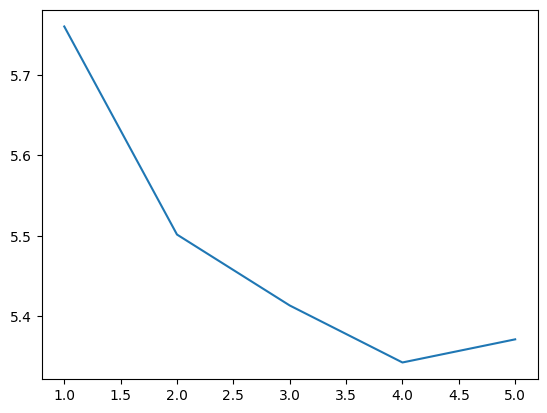

In [34]:
plt.plot(range(1,6), test_st_losses);

In [35]:
tokenizer_translator= AutoTokenizer.from_pretrained(
    "facebook/nllb-200-distilled-600M", src_lang="fra_Latn"
)

Translator = AutoModelForSeq2SeqLM.from_pretrained("facebook/nllb-200-distilled-600M")
Translator.to(device)
x = 1

In [48]:
SRC_VOCAB_SIZE = len(vocab_fr_s)
TGT_VOCAB_SIZE = len(vocab_en_t)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3


Student_dist = Seq2SeqTransformer(NUM_ENCODER_LAYERS, 
                                 NUM_DECODER_LAYERS,
                                 EMB_SIZE, SRC_VOCAB_SIZE, 
                                 TGT_VOCAB_SIZE,
                                 FFN_HID_DIM)

for p in Student_dist.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

Student_dist = Student_dist.to(device)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=1)

optimizer = torch.optim.Adam(
    Student_dist.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9
)

train_dist_losses, test_dist_losses = train_distillation_nlp(Student_dist, train_s_iter, optimizer, loss_fn, val_iter=test_s_iter, epochs=5,\
                                                         teacher=Teacher, translator=Translator, vocab_src_s=vocab_fr_s,\
                                                         SEED=20, tokenizer_transl=tokenizer_translator,\
                                                         vocab_src_t=vocab_en_t, tokenizer_src_t=tokenizer_de)

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched src_key_padding_mask and src_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 5/5 [1:00:12<00:00, 722.46s/it]


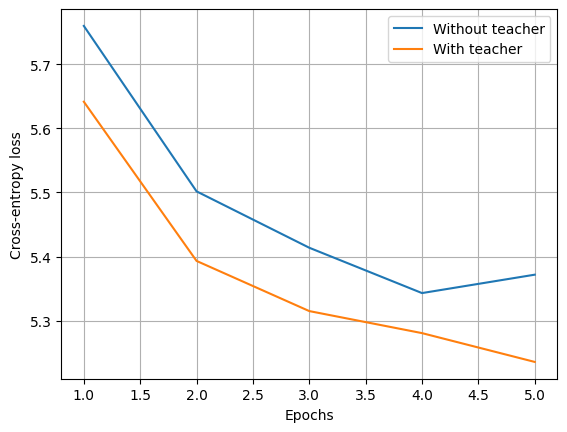

In [38]:
plt.plot(range(1,6), test_st_losses, label='Without teacher')
plt.plot(range(1,6), test_dist_losses, label='With teacher')
plt.xlabel('Epochs')
plt.ylabel('Cross-entropy loss')
plt.legend()
plt.grid()
plt.show()

In [39]:
arr_test_losses = []

In [49]:
arr_test_losses.append(test_dist_losses)

In [50]:
arr_test_losses

[[5.641830250620842,
  5.3930878937244415,
  5.314721271395683,
  5.280286103487015,
  5.235289856791496],
 [5.642995834350586,
  5.449973255395889,
  5.310828655958176,
  5.302960082888603,
  5.241671577095985],
 [5.6317655593156815,
  5.44185546040535,
  5.328742101788521,
  5.241836205124855,
  5.224618896842003]]

In [52]:
test_losses_stud = []

In [59]:
test_losses_stud.append(test_st_losses)

In [60]:
test_losses_stud

[[5.760256573557854,
  5.501785099506378,
  5.413675352931023,
  5.342855334281921,
  5.371595695614815],
 [5.755459934473038,
  5.616024374961853,
  5.368820235133171,
  5.459389954805374,
  5.381677612662315],
 [5.736733004450798,
  5.545000746846199,
  5.4287431836128235,
  5.390913873910904,
  5.346728906035423]]

In [61]:
losses = [arr_test_losses, test_losses_stud]

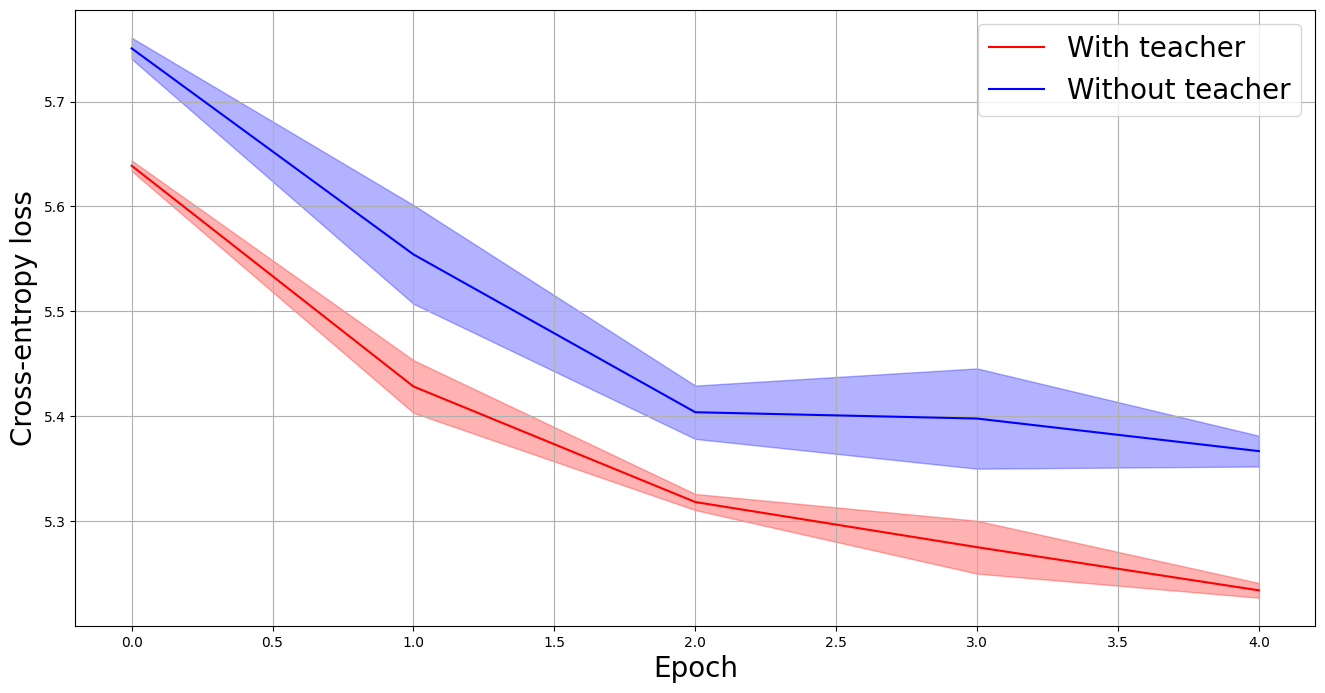

In [73]:
plt.figure(figsize=(16,8))
for loss, color, label in zip(losses, ['red', 'blue'], ['With teacher', 'Without teacher']):
    mean = np.array(loss).mean(0)
    std = np.array(loss).std(0)
    x_axis = np.arange(0, len(mean))   
    plt.plot(x_axis, mean, color=color, label=label)
    plt.fill_between(x_axis, mean-std, mean+std, alpha=0.3, color=color)

plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Cross-entropy loss', fontsize=20)
plt.grid()
plt.legend(loc='best', prop={'size': 20})
plt.show()

In [74]:
from nltk.translate.bleu_score import sentence_bleu


In [109]:
bleu_score_dist, bleu_score_st = 0, 0
for src, tgt in zip(test_s['fr'], test_s['en']):
    candidate = try_translate(Student_dist, [src], vocab_fr_s, vocab_en_t, tokenizer_fr)[0][0].split()
    bleu_score_dist += sentence_bleu([candidate], tgt.split(), weights=(1,0,0,0))
    candidate = try_translate(Student, [src], vocab_fr_s, vocab_en_t, tokenizer_fr)[0][0].split()
    bleu_score_st += sentence_bleu([candidate], tgt.split(), weights=(1,0,0,0))
print('With teacher:', bleu_score_dist/len(test_s['fr']))
print('Without teacher:', bleu_score_st/len(test_s['fr']))

/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

With teacher: 0.057165226117144446
Without teacher: 0.028276410551272682


In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
torch.save({
            'model_state_dict': Teacher.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, "/content/drive/MyDrive/Colab Notebooks/Teacher.pt")

In [21]:
torch.save({
            'model_state_dict': Student.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, "/content/drive/MyDrive/Colab Notebooks/Student1.pt")

In [53]:
torch.save({
            'model_state_dict': Student_dist.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, "/content/drive/MyDrive/Colab Notebooks/Student_dist_20.pt")

In [110]:
Student = Seq2SeqTransformer(NUM_ENCODER_LAYERS, 
                                 NUM_DECODER_LAYERS,
                                 EMB_SIZE, SRC_VOCAB_SIZE, 
                                 TGT_VOCAB_SIZE,
                                 FFN_HID_DIM)
optimizer = torch.optim.Adam(
    Student.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9
)

checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/Student1.pt')
Student.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

Student.eval()
Student.to(device)
x = 1